In [1]:
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt
import numpy
import scipy.io.wavfile
from scipy.fftpack import dct
from IPython.display import Audio

Populating the interactive namespace from numpy and matplotlib


In [23]:
sig_dur = 3.5
#file_name = 'OSR_us_000_0010_8k.wav'
file_name = 'sound/sweep.wav'

In [24]:
sample_rate, signal = scipy.io.wavfile.read(file_name)  
if len(signal)/sample_rate < sig_dur:
    sig_dur = len(signal)/sample_rate
signal = signal[0:int(sig_dur * sample_rate)]  

In [25]:
sample_rate

44100

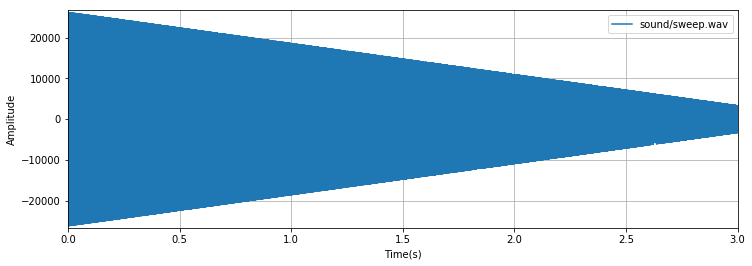

In [26]:
t = np.linspace(0, sig_dur, len(signal))
plt.figure(figsize=(12,4))
plt.plot(t, signal, label=file_name)
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.axis((0, sig_dur, min(signal)-500, max(signal)+500))
plt.legend()
plt.grid()

In [27]:
Audio(data = signal, rate = sample_rate)

In [28]:
pre_emphasis = 0.97
emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

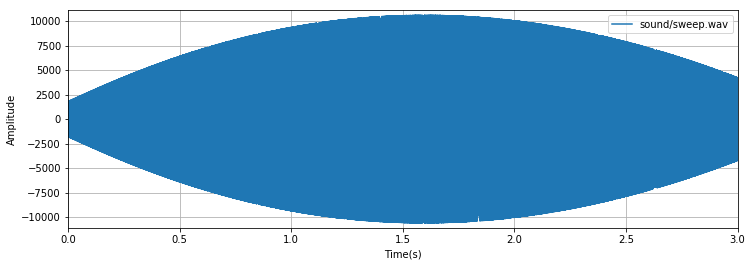

In [29]:
t = np.linspace(0, sig_dur, len(signal))
plt.figure(figsize=(12,4))
plt.plot(t, emphasized_signal, label=file_name)
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.axis((0, sig_dur, min(emphasized_signal)-500, max(emphasized_signal)+500))
plt.legend()
plt.grid()

In [30]:
Audio(data = emphasized_signal, rate = sample_rate)

In [10]:
frame_size = 0.025
frame_stride = 0.01

In [31]:
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length
z = numpy.zeros((pad_signal_length - signal_length))
pad_signal = numpy.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(numpy.int32, copy=False)]
frames *= numpy.hamming(frame_length)

In [32]:
NFFT = 512
mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

In [33]:
nfilt = 20
low_freq_mel = 0
high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = numpy.dot(pow_frames, fbank.T)
filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * numpy.log10(filter_banks)  # dB

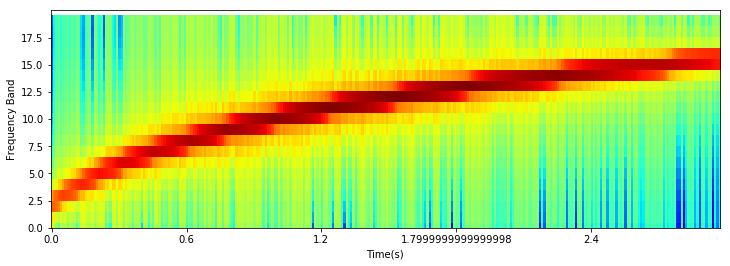

In [34]:
plt.figure(figsize=(12,4))
plt.imshow(filter_banks.T, cmap='jet', aspect='auto')
plt.ylim(0, nfilt)
plt.xlabel('Time(s)')
plt.ylabel('Frequency Band')
plt.xticks(np.arange(0, sig_dur*100, step=sig_dur*20), np.arange(0, sig_dur, step=sig_dur/5) )
plt.yticks(np.arange(0, nfilt, step=nfilt/8), np.arange(0, nfilt, step=np.round(nfilt/8, 2)) )
plt.show()

In [35]:
num_ceps = 12
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13

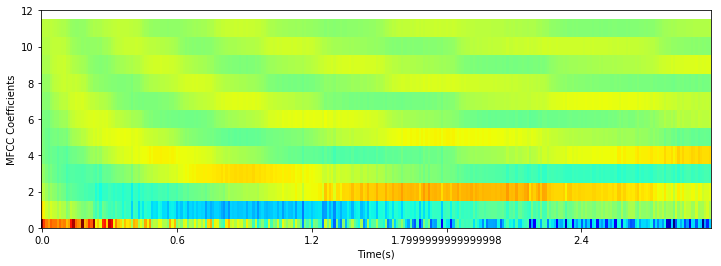

In [36]:
plt.figure(figsize=(12,4))
plt.imshow(mfcc.T, cmap='jet', aspect='auto')
plt.ylim(0, 12)
plt.xlabel('Time(s)')
plt.ylabel('MFCC Coefficients')
plt.xticks(np.arange(0, sig_dur*100, step=sig_dur*20), np.arange(0, sig_dur, step=sig_dur/5) )
plt.show()

In [37]:
cep_lifter = 6
(nframes, ncoeff) = mfcc.shape
n = numpy.arange(ncoeff)
lift = 1 + (cep_lifter / 2) * numpy.sin(numpy.pi * n / cep_lifter)
mfcc *= lift  #*

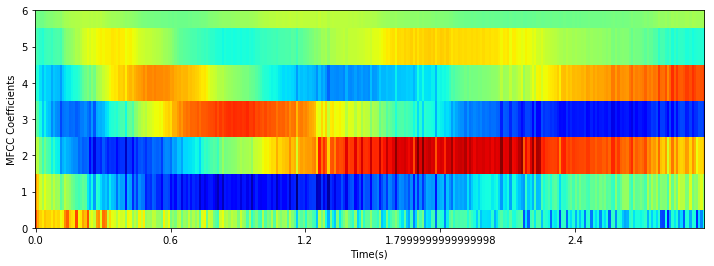

In [38]:
plt.figure(figsize=(12,4))
plt.imshow(mfcc.T, cmap='jet', aspect='auto')
plt.ylim(0, cep_lifter)
plt.xlabel('Time(s)')
plt.ylabel('MFCC Coefficients')
plt.xticks(np.arange(0, sig_dur*100, step=sig_dur*20), np.arange(0, sig_dur, step=sig_dur/5) )
plt.show()

In [39]:
filter_banks -= (numpy.mean(filter_banks, axis=0) + 1e-8)

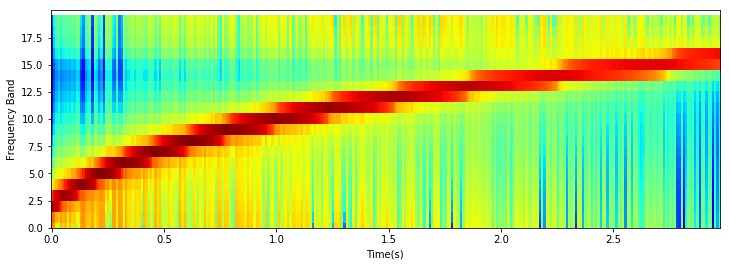

In [40]:
plt.figure(figsize=(12,4))
plt.imshow(filter_banks.T, cmap='jet', aspect='auto')
plt.ylim(0, nfilt)
plt.xlabel('Time(s)')
plt.ylabel('Frequency Band')
plt.xticks(np.arange(0, sig_dur*100, step=50), np.arange(0, sig_dur, step=0.5) )
plt.yticks(np.arange(0, nfilt, step=nfilt/8), np.arange(0, nfilt, step=np.round(nfilt/8, 2)) )
plt.show()

In [21]:
num_ceps = 12
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13
mfcc -= (numpy.mean(mfcc, axis=0) + 1e-8)

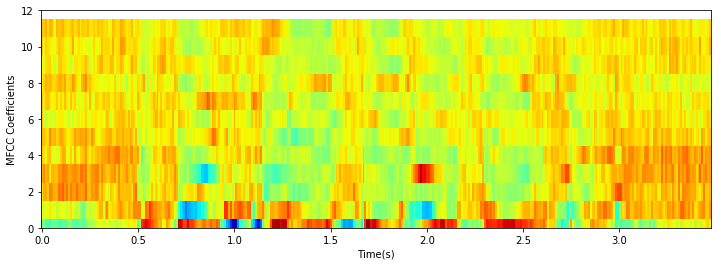

In [22]:
plt.figure(figsize=(12,4))
plt.imshow(mfcc.T, cmap='jet', aspect='auto')
plt.ylim(0, 12)
plt.xlabel('Time(s)')
plt.ylabel('MFCC Coefficients')
plt.xticks(np.arange(0, sig_dur*100, step=50), np.arange(0, sig_dur, step=0.5) )
plt.show()